In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, recall_score, r2_score
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split, StratifiedKFold, cross_validate, KFold, GridSearchCV, ParameterGrid, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import BaggingRegressor,BaggingClassifier, RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer, LabelEncoder
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [38]:
clean_data = pd.read_csv('clean_data.csv')
clean_data.loc[clean_data['Program Price'] == 'Free', 'Program Price'] = 1
clean_data.loc[clean_data['Program Price'] == 'Unknown', 'Program Price'] = 0
clean_data.loc[clean_data['Program Price'] == '$50 or Less', 'Program Price'] = 0
clean_data.loc[clean_data['Program Price'] == 'More Than $50', 'Program Price'] = 0
df = clean_data[['Id','Category Name','Program Price','Geographic Cluster Name','Start Date']]
df

/var/folders/t9/_x5y2dys63b6nz3nw8l_vrsh0000gn/T/ipykernel_39976/823332630.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  clean_data = pd.read_csv('clean_data.csv')


,Id,Category Name,Program Price,Geographic Cluster Name,Start Date
0,78752,Academic Support,1,NEAR WEST SIDE,2020-01-01
1,78752,Work + Career,1,NEAR WEST SIDE,2020-01-01
2,78749,Academic Support,1,NORTH LAWNDALE,2020-01-01
3,78749,Music & Art.,1,NORTH LAWNDALE,2020-01-01
4,84422,Building and Fixing Things,1,ROSELAND,2020-06-01
...,...,...,...,...,...
76503,148925,Healthcare,1,NEAR WEST SIDE,2023-09-09
76504,146348,Helping Your Community,1,HERMOSA,2023-10-14
76505,146348,Nature.,1,HERMOSA,2023-10-14
76506,146350,Helping Your Community,1,HERMOSA,2023-11-11


In [41]:
df['Start Date'] = pd.to_datetime(df['Start Date'])
df['Month'] = df['Start Date'].dt.strftime('%Y-%m')
df['Program Price'] = df['Program Price']
df_free = df[df['Program Price'] == 1]
df_not_free = df[df['Program Price'] == 0]

df_free = df_free.groupby(['Geographic Cluster Name', 'Month']).size().reset_index(name='Count')
df_not_free = df_not_free.groupby(['Geographic Cluster Name', 'Month']).size().reset_index(name='Count')


df_free

/var/folders/t9/_x5y2dys63b6nz3nw8l_vrsh0000gn/T/ipykernel_39976/3697962496.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Start Date'] = pd.to_datetime(df['Start Date'])
/var/folders/t9/_x5y2dys63b6nz3nw8l_vrsh0000gn/T/ipykernel_39976/3697962496.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Month'] = df['Start Date'].dt.strftime('%Y-%m')
/var/folders/t9/_x5y2dys63b6nz3nw8l_vrsh0000gn/T/ipykernel_39976/3697962496.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

,Geographic Cluster Name,Month,Count
0,ALBANY PARK,2021-06,1
1,ALBANY PARK,2021-08,2
2,ALBANY PARK,2021-09,12
3,ALBANY PARK,2021-10,1
4,ALBANY PARK,2021-11,1
...,...,...,...
1925,WOODLAWN,2022-11,1
1926,WOODLAWN,2022-12,12
1927,WOODLAWN,2023-01,15
1928,WOODLAWN,2023-02,2


In [42]:
df_free['Month'] = pd.to_datetime(df_free['Month'])
df_free.set_index('Month', inplace=True)
df_free = df_free.pivot(columns='Geographic Cluster Name', values='Count')

df_not_free['Month'] = pd.to_datetime(df_not_free['Month'])
df_not_free.set_index('Month', inplace=True)
df_not_free = df_not_free.pivot(columns='Geographic Cluster Name', values='Count')

df_free


Geographic Cluster Name,ALBANY PARK,ARCHER HEIGHTS,ARMOUR SQUARE,ASHBURN,AUBURN GRESHAM,AUSTIN,AVALON PARK,AVONDALE,BELMONT CRAGIN,BEVERLY,...,WASHINGTON HEIGHTS,WASHINGTON PARK,WEST ELSDON,WEST ENGLEWOOD,WEST GARFIELD PARK,WEST LAWN,WEST PULLMAN,WEST RIDGE,WEST TOWN,WOODLAWN
Month,,,,,,,,,,,,,,,,,,,,,
2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-01,NaN,2.0,NaN,1.0,1.0,13.0,NaN,1.0,NaN,NaN,...,1.0,6.0,NaN,7.0,14.0,NaN,NaN,NaN,6.0,7.0
2020-10-01,NaN,NaN,NaN,1.0,NaN,21.0,NaN,2.0,NaN,1.0,...,1.0,2.0,NaN,2.0,NaN,NaN,1.0,NaN,NaN,NaN
2020-11-01,NaN,2.0,NaN,1.0,3.0,11.0,NaN,NaN,1.0,NaN,...,3.0,5.0,NaN,7.0,15.0,1.0,NaN,3.0,6.0,6.0
2020-12-01,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
2021-01-01,NaN,2.0,6.0,1.0,10.0,18.0,3.0,NaN,3.0,NaN,...,6.0,6.0,NaN,10.0,16.0,1.0,4.0,4.0,8.0,12.0
2021-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN


In [65]:
# Train the SARIMA model and make predictions
predictions = {}
order = (1, 1, 0)  
seasonal_order = (0, 1, 1, 12)  

for column in df_free.columns:
    try:
        model = SARIMAX(df_free[column], order=order, seasonal_order=seasonal_order,
                        enforce_stationarity=False, enforce_invertibility=False)
        model_fit = model.fit(disp=False)
        pred = model_fit.get_forecast(steps=24)
        predictions[column] = pred.predicted_mean
    except Exception as e:
        print(f"Error occurred for column '{column}': {str(e)}")

preds_free = pd.DataFrame(predictions)
preds_free.index = pd.date_range(start=df_free.index[-1] + pd.DateOffset(months=1), periods=24, freq='M').strftime('%Y-%m')
preds_free.index.name = 'Date'
preds_free = preds_free.clip(lower=0)

# Train the SARIMA model and make predictions
predictions = {}
order = (1, 1, 0)  
seasonal_order = (0, 1, 1, 12)  

for column in df_not_free.columns:
    try:
        model = SARIMAX(df_not_free[column], order=order, seasonal_order=seasonal_order,
                        enforce_stationarity=False, enforce_invertibility=False)
        model_fit = model.fit(disp=False)
        pred = model_fit.get_forecast(steps=24)
        predictions[column] = pred.predicted_mean
    except Exception as e:
        print(f"Error occurred for column '{column}': {str(e)}")

preds_not_free = pd.DataFrame(predictions)
preds_not_free.index = pd.date_range(start=df_not_free.index[-1] + pd.DateOffset(months=1), periods=24, freq='M').strftime('%Y-%m')
preds_not_free.index.name = 'Date'
preds_not_free = preds_not_free.clip(lower=0)

preds_free

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `st

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(da

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/li

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(da

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(da

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/li

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(da

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/li

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(da

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(da

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(da

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(da

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueW

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_m

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueW

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3757: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid val

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueW

,ALBANY PARK,ARCHER HEIGHTS,ARMOUR SQUARE,ASHBURN,AUBURN GRESHAM,AUSTIN,AVALON PARK,AVONDALE,BELMONT CRAGIN,BEVERLY,...,WASHINGTON HEIGHTS,WASHINGTON PARK,WEST ELSDON,WEST ENGLEWOOD,WEST GARFIELD PARK,WEST LAWN,WEST PULLMAN,WEST RIDGE,WEST TOWN,WOODLAWN
Date,,,,,,,,,,,,,,,,,,,,,
2023-12,22.368375,1.997338,17.580239,24.389749,15.965496,26.090434,7.806840,NaN,12.388184,30.714234,...,56.909132,5.184779,0.0,10.785916,49.858503,10.958387,42.382813,9.999168,15.368681,0.177734
2024-01,14.323563,7.997338,22.604403,30.656831,25.225290,74.081906,8.806681,NaN,18.388255,39.635419,...,74.727320,7.044195,0.0,33.011370,34.603073,15.121278,93.533655,15.002924,39.919708,1.246830
2024-02,12.305881,2.997331,19.566356,18.750507,19.452994,22.084323,16.307081,NaN,11.721605,31.774471,...,63.498031,5.793629,0.0,7.111989,29.765849,12.584675,56.835816,5.335069,9.935529,0.000000
2024-03,23.509686,12.997334,17.539531,20.087130,16.375129,51.387902,20.639111,NaN,13.622071,29.751547,...,55.727766,4.778399,0.0,15.577439,43.660907,16.637773,70.256681,13.285586,23.873415,0.000000
2024-04,23.151970,1.997338,30.504417,33.323491,39.557593,119.479507,13.140042,NaN,15.054916,36.084759,...,79.393823,4.803235,0.0,29.608969,62.017276,24.042032,105.149801,12.335248,43.863492,1.457120
2024-05,12.739751,3.622523,22.048475,6.996823,10.691502,0.000000,4.150181,NaN,5.325591,22.204179,...,46.717451,2.022712,0.0,6.609782,0.000000,18.125093,89.936737,0.000000,15.812144,0.000000
2024-06,17.041869,5.994680,28.136657,37.886883,30.757682,42.478438,14.271261,NaN,15.445136,19.339949,...,71.384060,4.136601,0.0,16.952124,76.674872,28.898602,105.158696,6.058963,35.240705,0.000000
2024-07,35.341061,13.994679,33.037064,36.900955,30.331308,79.248574,14.734481,NaN,25.564457,44.122959,...,75.785484,4.331226,0.0,35.252787,70.112961,47.376166,124.049451,28.302019,37.192197,0.000000
2024-08,22.211959,10.994674,34.064038,31.999478,23.455323,69.710318,12.576405,NaN,16.538582,37.586031,...,78.028846,6.050595,0.0,40.536057,28.950958,29.832622,101.932041,27.664172,33.725525,0.000000


In [75]:
targets = ['AUSTIN','NORTH LAWNDALE','HUMBOLDT PARK','EAST GARFIELD PARK','ENGLEWOOD',
'AUBURN GRESHAM','WEST GARFIELD PARK','ROSELAND','GREATER GRAND CROSSING',
'WEST ENGLEWOOD','SOUTH SHORE','NEW CITY','CHICAGO LAWN','SOUTH LAWNDALE',
'WEST PULLMAN']
len(targets)

15

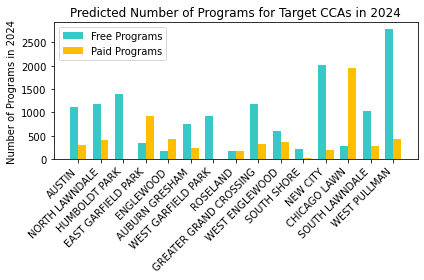

In [84]:
targets_free = preds_free.loc[:, targets].sum(axis=0)
targets_not_free = preds_not_free.loc[:, targets].sum(axis=0)

fig, ax = plt.subplots()
x = np.arange(len(targets))
bar_width = 0.35

plt.bar(x - bar_width/2, targets_free, bar_width, label='Free Programs', color = '#38C8C7')
plt.bar(x + bar_width/2, targets_not_free, bar_width, label='Paid Programs', color = '#FFBF00')

ax.set_ylabel('Number of Programs in 2024')
ax.set_xticks(x)
ax.set_xticklabels(targets, rotation=45, ha = 'right')
ax.set_title('Predicted Number of Programs for Target CCAs in 2024')  # Add a title to the plot
ax.legend()
plt.tight_layout() 

plt.show()
